## Random Tree Forest Model

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
# Read in data
train_final = pd.read_csv('../../DataSets/train_final.csv')
test_final = pd.read_csv('../../DataSets/test_final.csv')

In [3]:
# Set up X_train, y_train, X_test

drop_columns =  ['Address', 'Block', 'Street', 'AddressNumberAndStreet',
                 'Latitude', 'Longitude', 'Species', 'Trap',                             
                 'AddressAccuracy', 'month_year',
                 'year', 'month', 'day', 'tarsalis', 'erraticus', 'unspecified',
                 'T040', 'T200B', 'T234', 'T090A', 'T090C', 'T090B', 
                 'T218C', 'T128A', 'T218B', 'T218A', 'T002A', 
                 'T002B', 'T200A', 'T065A']

X = train_final.drop(columns = drop_columns + ['tot_mosquitos', 'WnvPresent'])
y = train_final['WnvPresent']
kaggle_test = test_final.drop(columns = drop_columns)

#train_test_split (before smote so that val set is not leaked when smote)
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size= 0.25,
                                                  random_state= 42,
                                                  stratify= y)

#Scaling
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_val_ss = ss.transform(X_val)

# SMOTE
sm = SMOTE(random_state = 42)
Xsm_train, ysm_train = sm.fit_resample(X_train_ss, y_train)

### Baseline Scores

#### Before Smote

In [4]:
y.value_counts(normalize = True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

In [5]:
y_train.value_counts(normalize = True)

0    0.946879
1    0.053121
Name: WnvPresent, dtype: float64

#### After Smote

In [6]:
ysm_train.value_counts(normalize = True)

0    0.5
1    0.5
Name: WnvPresent, dtype: float64

### Model 1: 1st Run

In [7]:
rt1 = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
params1 = {'max_features': [0.1,0.2,0.3],
          'min_samples_leaf': [10,50,100],
          'max_depth': [15,25],
          'min_samples_split': [3,6],          
          }
        
gs1 = GridSearchCV(rt1,
                   param_grid= params1,
                   cv = 5,
                   scoring = 'roc_auc',
                   n_jobs = -1
                  )

In [8]:
gs1.fit(Xsm_train, ysm_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [15, 25], 'max_features': [0.1, 0.2, 0.3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [3, 6]},
             scoring='roc_auc')

Best Grid Search Score: 0.9869615269486702
Best Params: {'max_depth': 25, 'max_features': 0.3, 'min_samples_leaf': 10, 'min_samples_split': 3}
Best Model train set Score: 0.9598462544978738
Best Model val set Score: 0.9400836042731073
Train set ROC Score: 0.9920937232384069
Val set ROC Score: 0.8504448344991955


,0,1
0,Accurary,0.940084
1,Misclassification,0.059916
2,Sensitivity,0.087719
3,Specificity,0.987739
4,Precision,0.285714


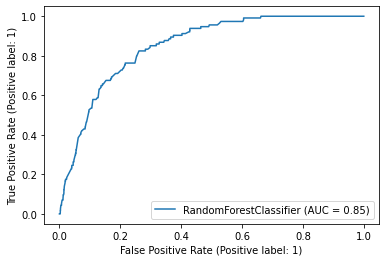

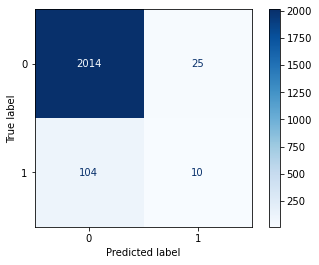

In [9]:
print(f'Best Grid Search Score: {gs1.best_score_}')
print(f'Best Params: {gs1.best_params_}')

model1 = gs1.best_estimator_
print(f'Best Model train set Score: {model1.score(Xsm_train, ysm_train)}')
print(f'Best Model val set Score: {model1.score(X_val_ss,y_val)}')
print(f'Train set ROC Score: {roc_auc_score(ysm_train, [i[1] for i in model1.predict_proba(Xsm_train)])}')
print(f'Val set ROC Score: {roc_auc_score(y_val, [i[1] for i in model1.predict_proba(X_val_ss)])}')
plot_roc_curve(model1, X_val_ss, y_val);

plot_confusion_matrix(model1, X_val_ss, y_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(y_val, model1.predict(X_val_ss)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

Looks overfitted. This is expected as our gridsearch is running over the dataset whereby SMOTE have oversampled the minority class.

### Model 2: Limiting max_depth and ccp_alpha to solve overfitting

In [10]:
rt2 = RandomForestClassifier(n_estimators = 200, n_jobs = -1)
params2 = {'max_features': [0.1,0.2],
           'min_samples_leaf': [100,200],
           'max_depth': [10],
           'min_samples_split': [3,6],     
           'ccp_alpha':[0.1],
          }  
           
gs2 = GridSearchCV(rt2,
                   param_grid= params2,
                   cv = 5,
                   scoring = 'roc_auc',
                   n_jobs = -1
                  )

In [11]:
gs2.fit(Xsm_train, ysm_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.1], 'max_depth': [10],
                         'max_features': [0.1, 0.2],
                         'min_samples_leaf': [100, 200],
                         'min_samples_split': [3, 6]},
             scoring='roc_auc')

Best Grid Search Score: 0.7514295828283543
Best Params: {'ccp_alpha': 0.1, 'max_depth': 10, 'max_features': 0.2, 'min_samples_leaf': 100, 'min_samples_split': 6}
Best Model train set Score: 0.7418220477592411
Best Model val set Score: 0.7004180213655364
Train set ROC Score: 0.7417963528847653
Val set ROC Score: 0.7010488457534223


,0,1
0,Accurary,0.700418
1,Misclassification,0.299582
2,Sensitivity,0.701754
3,Specificity,0.700343
4,Precision,0.115774


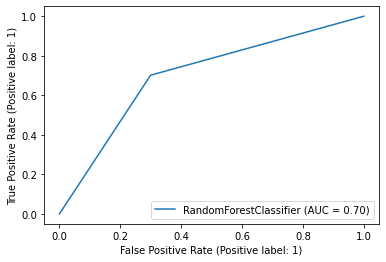

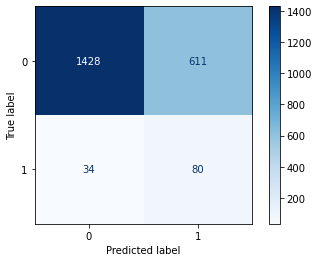

In [12]:
print(f'Best Grid Search Score: {gs2.best_score_}')
print(f'Best Params: {gs2.best_params_}')

model2 = gs2.best_estimator_
print(f'Best Model train set Score: {model2.score(Xsm_train, ysm_train)}')
print(f'Best Model val set Score: {model2.score(X_val_ss,y_val)}')
print(f'Train set ROC Score: {roc_auc_score(ysm_train, [i[1] for i in model2.predict_proba(Xsm_train)])}')
print(f'Val set ROC Score: {roc_auc_score(y_val, [i[1] for i in model2.predict_proba(X_val_ss)])}')
plot_roc_curve(model2, X_val_ss, y_val);

plot_confusion_matrix(model2, X_val_ss, y_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(y_val, model2.predict(X_val_ss)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

We tried a couple of different hyperparameters within GridSearch but the resulting model is always overfitted since this is an imbalance class. GridSearch always return the hyperparameters that return the highest scoring but this doesn't help with overfitting. Even increasing the folds of crossvalidation doesn't helps here as the input to GridSearch is after using SMOTE where the minority class is oversampled and not an imbalanced class. 

In the end, we choose to keep the tree from overgrowing by capping max_depth and introducing ccp_alpha while gridsearching over the rest and the score drop alot.

### Model 3: Using Imbalance Pipeline to perform GridSearchCV better

In [13]:
pipe = imbpipeline([('ss', StandardScaler()),
                    ('smote', SMOTE(random_state = 42)),
                    ('rt', RandomForestClassifier(n_estimators = 500, n_jobs = -1))
                   ])

        
params3 = {'rt__max_features': [0.1, 0.2, 0.3],
           'rt__min_samples_leaf': [5, 10, 30],
           'rt__max_depth': [10, 15, 25],      
           'rt__min_samples_split': [3, 6],
          }

gs3 = GridSearchCV(pipe,
                   param_grid= params3,
                   cv = 5,
                   scoring = 'roc_auc',
                   n_jobs = -1
                  )

In [14]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('rt',
                                        RandomForestClassifier(n_estimators=500,
                                                               n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rt__max_depth': [10, 15, 25],
                         'rt__max_features': [0.1, 0.2, 0.3],
                         'rt__min_samples_leaf': [5, 10, 30],
                         'rt__min_samples_split': [3, 6]},
             scoring='roc_auc')

Best Grid Search Score: 0.8097728363868869
Best Params: {'rt__max_depth': 15, 'rt__max_features': 0.1, 'rt__min_samples_leaf': 5, 'rt__min_samples_split': 3}
Best Model train set Score: 0.9304630633421094
Best Model val set Score: 0.9256850905712959
Train set ROC Score: 0.8837884375676529
Val set ROC Score: 0.85516636121938


,0,1
0,Accurary,0.925685
1,Misclassification,0.074315
2,Sensitivity,0.157895
3,Specificity,0.968612
4,Precision,0.219512


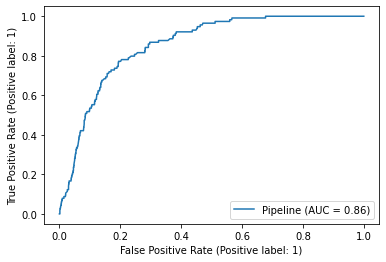

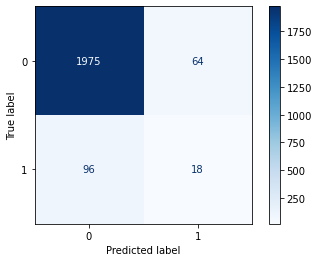

In [15]:
print(f'Best Grid Search Score: {gs3.best_score_}')
print(f'Best Params: {gs3.best_params_}')

model3 = gs3.best_estimator_
print(f'Best Model train set Score: {model3.score(X_train, y_train)}')
print(f'Best Model val set Score: {model3.score(X_val,y_val)}')
print(f'Train set ROC Score: {roc_auc_score(y_train, [i[1] for i in model3.predict_proba(X_train)])}')
print(f'Val set ROC Score: {roc_auc_score(y_val, [i[1] for i in model3.predict_proba(X_val)])}')
plot_roc_curve(model3, X_val, y_val);

plot_confusion_matrix(model3, X_val, y_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(y_val, model3.predict(X_val)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

With the pipeline from the imblearn library, only can we GridSearch meaningfully. The metrics results from this model surpass model 1 and 2 and the model return with the best Val Set ROC-AUC Score of all the models.

### Model 4: BalancedRandomForestClassifier

In [16]:
rt4 = BalancedRandomForestClassifier(n_estimators = 500, random_state=42, n_jobs = -1)

params4 = {'max_features': [0.1, 0.2, 0.3],
           'min_samples_leaf': [5, 10, 30],
           'max_depth': [10, 15, 25],
           'min_samples_split': [3, 6],
          }
           
gs4 = GridSearchCV(rt4,
                   param_grid= params4,
                   cv = 5,
                   scoring = 'roc_auc',
                   n_jobs = -1
                  )

In [17]:
gs4.fit(X_train_ss, y_train)

GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(n_estimators=500,
                                                      n_jobs=-1,
                                                      random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 25],
                         'max_features': [0.1, 0.2, 0.3],
                         'min_samples_leaf': [5, 10, 30],
                         'min_samples_split': [3, 6]},
             scoring='roc_auc')

Best Grid Search Score: 0.8137351309630899
Best Params: {'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 3}
Best Model train set Score: 0.6958339786278458
Best Model val set Score: 0.688341848583372
Train set ROC Score: 0.8500819225769658
Val set ROC Score: 0.839046488216618


,0,1
0,Accurary,0.688342
1,Misclassification,0.311658
2,Sensitivity,0.815789
3,Specificity,0.681216
4,Precision,0.125168


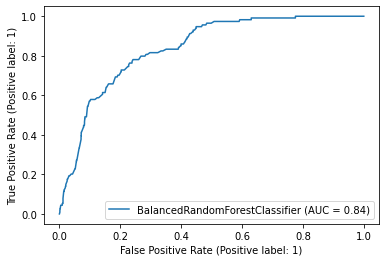

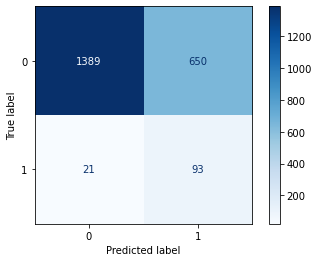

In [18]:
print(f'Best Grid Search Score: {gs4.best_score_}')
print(f'Best Params: {gs4.best_params_}')

model4 = gs4.best_estimator_
print(f'Best Model train set Score: {model4.score(X_train_ss, y_train)}')
print(f'Best Model val set Score: {model4.score(X_val_ss,y_val)}')
print(f'Train set ROC Score: {roc_auc_score(y_train, [i[1] for i in model4.predict_proba(X_train_ss)])}')
print(f'Val set ROC Score: {roc_auc_score(y_val, [i[1] for i in model4.predict_proba(X_val_ss)])}')
plot_roc_curve(model4, X_val_ss, y_val);

plot_confusion_matrix(model4, X_val_ss, y_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(y_val, model4.predict(X_val_ss)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

We are trying out the BalancedRandomForestClassifier here which is similar to using the Pipeline from the imblearn library. The accuracy is lower than Model3 while the ROC_AUC scores are comparable.

### Best Model: Model 3

#### Most important Features:

In [25]:
coefficients = pd.DataFrame(model3[-1].feature_importances_, index = X_train.columns, columns = ['features'])
display(coefficients.sort_values('features',ascending = False).head(10))

,features
8,0.106106
T900,0.071612
pipiens,0.063308
restuans,0.055033
7,0.049610
pipiens/restuans,0.042288
Tavg,0.035297
DewPoint_roll5,0.031723
DewPoint_roll6,0.028816
StnPressure,0.028791


### Refitting

Final Model Fullset Score: 0.9435540069686411
Final Model Fullset ROC Score: 0.8880323817923138


Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rt',
                 RandomForestClassifier(max_depth=15, max_features=0.1,
                                        min_samples_leaf=5, min_samples_split=3,
                                        n_estimators=500))])

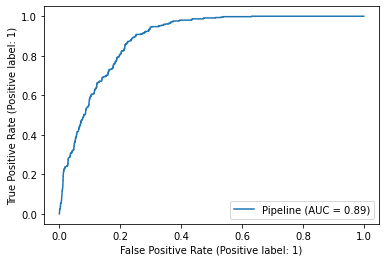

In [20]:
rt_final = imbpipeline([('ss', StandardScaler()),
                        ('smote', SMOTE(random_state = 42)),
                        ('rt', RandomForestClassifier(n_estimators= 500))
                       ])

rt_final.set_params(**gs3.best_params_)

rt_final.fit(X, y)

print(f'Final Model Fullset Score: {rt_final.score(X, y)}')
print(f'Final Model Fullset ROC Score: {roc_auc_score(y, [i[1] for i in rt_final.predict_proba(X)])}')
plot_roc_curve(rt_final, X, y);

rt_final

### Kaggle Submission

In [21]:
kaggle_test = test_final.drop(columns = drop_columns)
kaggle_submission = kaggle_test[['Id']].copy()
kaggle_test = kaggle_test.drop(columns = ['Id'])

kaggle_submission['WnvPresent'] = rt_final.predict_proba(kaggle_test)[:,1]


In [22]:
kaggle_submission.head()

,Id,WnvPresent
0,1,0.229059
1,2,0.198695
2,3,0.311205
3,4,0.234440
4,5,0.209649


In [23]:
kaggle_submission.to_csv('../../DataSets/kaggle_submission_rt.csv', index=False)

### Conclusion

|                                                                                                                       | Train Set Accuracy Score | Val Set Accuracy Score | Train Set ROC-AUC Score | Val Set ROC-AUC Score | Kaggle Test Set Score (After refitting with full dataset) | Best Params                                                                                               |
|-----------------------------------------------------------------------------------------------------------------------|--------------------------|------------------------|-------------------------|-----------------------|-----------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| Model 1: 1st Run. GridSearch without Pipeline from Imblearn                                                           | 0.96                     | 0.938                  | 0.992                   | 0.848                 | 0.703                                                     | {'max_depth': 25, 'max_features': 0.3, 'min_samples_leaf': 10, 'min_samples_split': 6}                    |
| Model 2: GridSearch without Pipeline from Imblearn (Constrain the model using hyperparameters for fixing overfitting) | 0.742                    | 0.7                    | 0.742                   | 0.7                   | 0.59                                                      | {'ccp_alpha': 0.1, 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 200, 'min_samples_split': 6} |
| Model 3: GridSearch using Pipeline from Imblearn                                                                      | 0.931                    | 0.926                  | 0.884                   | 0.854                 | 0.729                                                     | {'rt__max_depth': 15, 'rt__max_features': 0.1, 'rt__min_samples_leaf': 5, 'rt__min_samples_split': 6}     |
| Model 4: GridSearch using BalancedRandomForestClassifier                                                              | 0.696                    | 0.688                  | 0.85                    | 0.839                 | 0.694                                                     | {'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 3}                     |

In model 1 and 2, without using the imbalance pipeline, we tried a couple of different hyperparameters within GridSearch but the resulting model is always overfitted since this is an imbalance class. GridSearch always return the hyperparameters that return the highest scoring but this doesn't help with overfitting. Even increasing the folds of crossvalidation doesn't helps here as the input to GridSearch is after using SMOTE where the minority class is oversampled and not an imbalanced class. 

The only way we can prevent overfitting is to manually capped some of the hyperparameters that prevent overfitting like 'max_depth', 'max_features', 'max_leaf_nodes', 'min_samples_leaf' and 'min_samples_split' and gridsearch over the rest of hyperparameters like 'n_estimators. In the end, we choose to keep the tree from overgrowing by capping max_depth and introducing ccp_alpha while gridsearching over the rest. In our attempt to prevent overfitting, we sacrificed alot on the ROC_AUC score as the gridsearch wasn't working and we weren't finding the correct hyperparameters.

In model 3, 4, we seek to GridSearch more meaningfully using the pipeline from imblearn library or using BalanceRandomForestClassifier which randomly under-samples each boostrap sample to balance it.. In both cases, we obtained models that give better results across all metrics compared to model2. The ROC_AUC scores for both the train and val set are also higher than model2. There was also no sign of overfitting. When we submit the result to Kaggle. Model3 achieve the highest Kaggle Score of 0.729 and Model4 0.694. Model3 and Model4 are more robust than Model1. Model3 metrics are better than Model4 and we conclude Model 3 as our best randomforestclassifier model.